In [3]:
import csv
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

import os
print(os.getcwd())

/workspaces/Krafthack_SopraSteria_Team3


In [4]:
bolt_pretension = pd.read_csv("data_krafthack/bolt_pretension.csv")
dataset_1 = pd.read_parquet("data_krafthack/input_dataset-1.parquet", engine='fastparquet')
dataset_2 =pd.read_parquet("data_krafthack/input_dataset-2.parquet", engine='fastparquet')
prediction_input = pd.read_parquet("data_krafthack/prediction_input.parquet", engine='fastparquet')

dataset_2.reset_index(inplace=True)

In [62]:
def data_prep():

    # Include datetime variable as variable
    df = dataset_2.rename(columns = {'timepoints':'time'})

    # Drop vibration
    df.drop("lower_bearing_vib_vrt", inplace=True, axis=1)
    df.drop("turbine_bearing_vib_vrt", inplace=True, axis=1)

    # Remove all missing values
    df = df.dropna()

    # Make "mode" into dummy variable
    y = pd.get_dummies(df["mode"], prefix="Mode")
    df = df.join(y)
    df.drop("mode", inplace=True, axis=1)

    # Transform the date variable
    df['time_hour'] = df['time'].dt.hour
    df['time_weekday'] = df['time'].dt.dayofweek
    df.drop("time", inplace=True, axis=1)

    #x = np.array([i for i in range(df.shape[0])])
    #x = pd.DataFrame(x, columns=["time_counter"])
    #df = df.join(x)

    # Make the different datasets

    df_min = df[["time_weekday", "time_hour", "Unit_4_Power", "Unit_4_Reactive Power", "Turbine_Guide Vane Opening",
                "Turbine_Pressure Drafttube", "Turbine_Pressure Spiral Casing", "Turbine_Rotational Speed",
                "Mode_start", "Mode_operation"]]

    df_all = df[["time_weekday", "time_hour", "Unit_4_Power", "Unit_4_Reactive Power", "Turbine_Guide Vane Opening",
                "Turbine_Pressure Drafttube", "Turbine_Pressure Spiral Casing", "Turbine_Rotational Speed",
                "Mode_start", "Mode_operation",
                "Bolt_1_Torsion", "Bolt_2_Torsion", "Bolt_3_Torsion", "Bolt_4_Torsion",
                "Bolt_5_Torsion", "Bolt_6_Torsion"]]

    df_bolt1 = df["Bolt_1_Tensile"]
    df_bolt2 = df["Bolt_2_Tensile"]
    df_bolt3 = df["Bolt_3_Tensile"]
    df_bolt4 = df["Bolt_4_Tensile"]
    df_bolt5 = df["Bolt_5_Tensile"]
    df_bolt6 = df["Bolt_6_Tensile"]

    # Make test/train split 70/30

    len = df.shape[0]
    size_train = int(np.floor(len*0.8))
    size_test = int(len - size_train)
    print("Size train: ", size_train)
    print("Size test: ", size_test)

    df_min_train = df_min.head(size_train)
    df_min_test = df_min.tail(size_test)

    df_all_train = df_all.head(size_train)
    df_all_test = df_all.tail(size_test)

    df_bolt1_train = df_bolt1.head(size_train)
    df_bolt1_test = df_bolt1.tail(size_test)

    df_bolt2_train = df_bolt2.head(size_train)
    df_bolt2_test = df_bolt2.tail(size_test)

    df_bolt3_train = df_bolt3.head(size_train)
    df_bolt3_test = df_bolt3.tail(size_test)

    df_bolt4_train = df_bolt4.head(size_train)
    df_bolt4_test = df_bolt4.tail(size_test)

    df_bolt5_train = df_bolt5.head(size_train)
    df_bolt5_test = df_bolt5.tail(size_test)

    df_bolt6_train = df_bolt6.head(size_train)
    df_bolt6_test = df_bolt6.tail(size_test)

    return df_min_train, df_min_test, df_all_train, df_all_test, df_bolt1_train, df_bolt1_test, df_bolt2_train, df_bolt2_test, df_bolt3_train, df_bolt3_test, df_bolt4_train, df_bolt4_test, df_bolt5_train, df_bolt5_test, df_bolt6_train, df_bolt6_test, size_test, size_train

df_min_train, df_min_test, df_all_train, df_all_test, df_bolt1_train, df_bolt1_test, df_bolt2_train, df_bolt2_test, df_bolt3_train, df_bolt3_test, df_bolt4_train, df_bolt4_test, df_bolt5_train, df_bolt5_test, df_bolt6_train, df_bolt6_test, size_test, size_train = data_prep()

Size train:  1400000
Size test:  350000


In [65]:
# Add last observed value at each timestep
x = np.array(df_bolt1_train)
y = np.zeros(df_min_train.shape[0])
for i in range(df_min_train.shape[0]):
    if i == 0:
        y[i] = x[i]
    else:
        y[i] = x[i-1]

df_min_bolt1_train = df_min_train.copy(deep=True)
df_min_bolt1_train["Last_bolt1"] = y

In [73]:
# Linear regression model

x_train = df_min_bolt1_train
y_train = df_bolt1_train

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_train)
print("MAPE training: ", mean_absolute_percentage_error(y_train, y_pred))

#y = np.array(abs(y_train-y_pred))
#x = np.array(x_train["Mode_operation"])
#plt.figure()
#plt.scatter(y, x)
#plt.xlabel("Diff y_true - y_pred")
#plt.ylabel("Mode (1 operation, 0 start)")
#plt.title("Difference in error between operation and start")
#plt.show()

MAPE training:  2.4158183146476983e-05


MAPE training:  0.016637557229301866


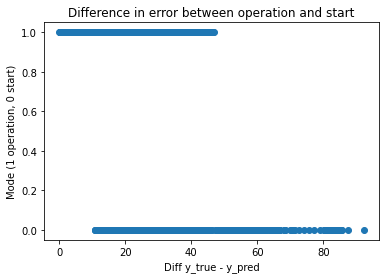

In [72]:
# Test set
y_train = df_min_test
y_test = df_bolt1_test

y_pred = model.predict(y_train)
print("MAPE training: ", mean_absolute_percentage_error(y_test, y_pred))

y = np.array(abs(y_test-y_pred))
x = np.array(y_train["Mode_operation"])
plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

In [79]:
# Test set
y_train = df_min_test
y_test = df_bolt1_test
last_y = float(df_bolt1_train.iloc[df_bolt1_train.shape[0]-1])
y_predicted = np.zeros(3000) #df_bolt1_test.shape[0]

x = y_train.copy(deep=True)
x["Last_bolt1"] = np.zeros(x.shape[0])

for i in range(3000): #df_bolt1_test.shape[0]
    z = x.iloc[[i]]
    z["Last_bolt1"] = last_y

    print(z)
    
    y_pred = model.predict(x)
    y_predicted[i] = y_pred
    last_y = y_pred

         time_weekday  time_hour  Unit_4_Power  Unit_4_Reactive Power  \
1404825             6         15    311.781272              25.866796   

         Turbine_Guide Vane Opening  Turbine_Pressure Drafttube  \
1404825                   94.396592                  150.898834   

         Turbine_Pressure Spiral Casing  Turbine_Rotational Speed  Mode_start  \
1404825                     5297.672259                108.126568           0   

         Mode_operation   Last_bolt1  
1404825               1  1619.792326  


/tmp/ipykernel_24690/1515107280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z["Last_bolt1"] = last_y


ValueError: setting an array element with a sequence.

In [77]:
print("MAPE training: ", mean_absolute_percentage_error(y_test[:3000], y_predicted))

MAPE training:  0.003508650890258494


In [158]:
# Test on prediction_input

d = {"time": prediction_input.index}
res = pd.DataFrame(data=d)

y = pd.get_dummies(prediction_input["mode"], prefix="Mode")
df_test = prediction_input.join(y)
df_test.drop("mode", inplace=True, axis=1)

df_test.reset_index(inplace=True)
df_test = df_test.rename(columns = {'timepoints':'time'})
df_test['time_hour'] = df_test["time"].dt.hour
df_test['time_weekday'] = df_test["time"].dt.dayofweek
df_test.drop("time", inplace=True, axis=1)

df_test = df_test[['time_weekday', 'time_hour', 'Unit_4_Power', 'Unit_4_Reactive Power',
                    'Turbine_Guide Vane Opening', 'Turbine_Pressure Drafttube',
                    'Turbine_Pressure Spiral Casing', 'Turbine_Rotational Speed',
                    'Mode_start', 'Mode_operation']]

Index(['time_weekday', 'time_hour', 'Unit_4_Power', 'Unit_4_Reactive Power',
       'Turbine_Guide Vane Opening', 'Turbine_Pressure Drafttube',
       'Turbine_Pressure Spiral Casing', 'Turbine_Rotational Speed',
       'Mode_start', 'Mode_operation'],
      dtype='object')

In [175]:
y_pred = model.predict(df_test)

y_pred
res["Bolt_6_Tensile"] = y_pred

In [179]:
res

res.to_csv("lin_reg_simple.csv", index=False, sep='\t')

,time,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
0,1971-01-25 11:06:49,1602.048026,1483.364574,1685.323865,1603.115791,1637.478174,1676.569610
1,1971-01-25 11:06:50,1601.945445,1483.301325,1685.285715,1603.122388,1637.491443,1676.559883
2,1971-01-25 11:06:51,1601.823914,1483.226334,1685.240646,1603.129688,1637.506399,1676.548015
3,1971-01-25 11:06:52,1601.702383,1483.151343,1685.195577,1603.136987,1637.521356,1676.536146
4,1971-01-25 11:06:53,1601.589688,1483.082493,1685.154940,1603.143388,1637.534815,1676.526306
...,...,...,...,...,...,...,...
226359,1971-02-03 20:16:19,1663.042254,1522.928987,1713.543284,1588.991713,1622.618541,1684.094069
226360,1971-02-03 20:16:20,1663.950064,1523.542488,1713.964901,1588.799612,1622.432277,1684.246162
226361,1971-02-03 20:16:21,1664.858302,1524.156299,1714.386718,1588.607528,1622.246046,1684.398405
226362,1971-02-03 20:16:22,1665.780707,1524.778907,1714.814404,1588.415179,1622.060283,1684.553878


r squre training:  0.9973134974193961
MAPE training:  0.0001288475356330117


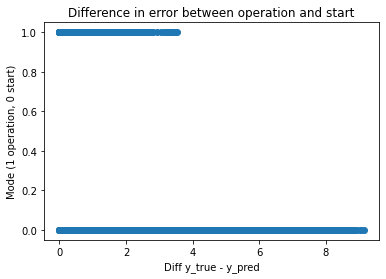

In [60]:
# Check model on all data

x_train = df_all_train
y_train = df_bolt1_train

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_train)
print("r squre training: ", model.score(x_train, y_train))
print("MAPE training: ", mean_absolute_percentage_error(y_train, y_pred))

y = np.array(abs(y_train-y_pred))
x = np.array(x_train["Mode_operation"])

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

r squre training:  1.0
MAPE training:  0.002607246621209129


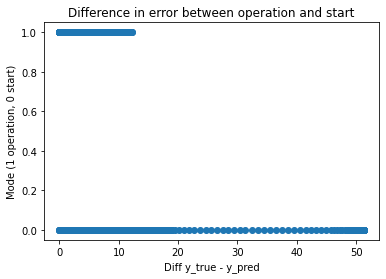

In [61]:
# Test set
y_train = df_all_test
y_test = df_bolt1_test

y_pred = model.predict(y_train)

print("r squre training: ", model.score(y_train, y_pred))
print("MAPE training: ", mean_absolute_percentage_error(y_test, y_pred))

y = np.array(abs(y_test-y_pred))
x = np.array(y_train["Mode_operation"])

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

In [ ]:
# Use the model on the real test data...

r squre training:  0.7041160722192203
MAPE training:  0.0013887807061450943


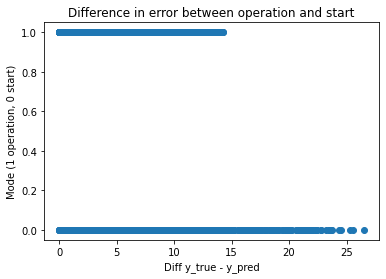

In [69]:
# Tree model

x_train = df_min_bolt1_train
y_train = df_bolt1_train

model = RandomForestRegressor(max_depth=4, n_estimators=100, criterion="absolute_error", map_depth=3, max_features=4)
model.fit(x_train, y_train)

importance = model.feature_importances_
importance

In [ ]:
y_pred = model.predict(x_train)
print("r squre training: ", model.score(x_train, y_train))
print("MAPE training: ", mean_absolute_percentage_error(y_train, y_pred))

y = np.array(abs(y_train-y_pred))
x = np.array(x_train["Mode_operation"])

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

In [73]:
# Test set
y_train = df_min_test
y_test = df_bolt1_test

y_pred = model.predict(y_train)

print("r squre training: ", model.score(y_train, y_pred))
print("MAPE training: ", mean_absolute_percentage_error(y_test, y_pred))

y = np.array(abs(y_test-y_pred))
x = np.array(y_train["Mode_operation"])

print("Number in operation: ", np.sum(x))
print("Number in start: ", len(x)-np.sum(x))

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Bolt_1_Torsion
- Bolt_2_Torsion
- Bolt_3_Torsion
- Bolt_4_Torsion
- Bolt_5_Torsion
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 10 features, but RandomForestRegressor is expecting 16 features as input.

r squre training:  0.9657703924252521
MAPE training:  0.0004385107909372511


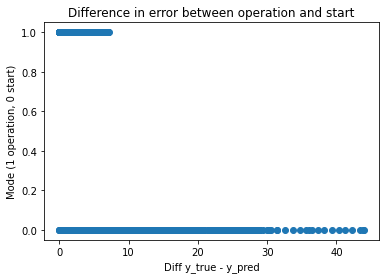

In [76]:
# Check model on all data

x_train = df_all_train
y_train = df_bolt1_train

model = RandomForestRegressor(max_depth=4, n_estimators=100, criterion="absolute_error", map_depth=3, max_features=4)
model.fit(x_train, y_train)

y_pred = model.predict(x_train)
print("r squre training: ", model.score(x_train, y_train))
print("MAPE training: ", mean_absolute_percentage_error(y_train, y_pred))

y = np.array(abs(y_train-y_pred))
x = np.array(x_train["Mode_operation"])

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

In [75]:
# Test set
y_train = df_all_test
y_test = df_bolt1_test

y_pred = model.predict(y_train)

print("r squre training: ", model.score(y_train, y_pred))
print("MAPE training: ", mean_absolute_percentage_error(y_test, y_pred))

y = np.array(abs(y_test-y_pred))
x = np.array(y_train["Mode_operation"])

print("Number in operation: ", np.sum(x))
print("Number in start: ", y_train.shape[0]-np.sum(x))

plt.figure()
plt.scatter(y, x)
plt.xlabel("Diff y_true - y_pred")
plt.ylabel("Mode (1 operation, 0 start)")
plt.title("Difference in error between operation and start")
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:993: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:993: RuntimeWarning: invalid value encountered in true_divide
  y_hat /= len(self.estimators_)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

x_train = df_min_train
y_train = df_bolt1_train

model = XGBRegressor(booster="gbtree", learning_rate=0.2, gamma=0.1, max_depth=6, eval_metric="mae")

model.fit(x_train, y_train)

# make predictions for test data
x_test = df_min_test
y_test = df_bolt1_test

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAPE: ", mean_absolute_percentage_error(y_test, predictions))

MAPE:  0.011685950505447278
